In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import re
import pandas as pd

from prepare import prepare_logs
import lessons_prep
import bollinger_bands
import env

plt.style.use('tableau-colorblind10')
plt.rcParams['figure.figsize'] = (13, 5)

# Anomaly detection in currriculum logs data

In [2]:
#df = prepare_logs()
#df.to_csv("prepared_logs.csv")
df = pd.read_csv("prepared_logs.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df.sample()

,time,path,user_id,ip,name,start_date,end_date,cohort_path_counts
datetime,,,,,,,,
2021-03-07 12:53:17,12:53:17,javascript-i,865,71.146.119.5,Marco-Java,2021-01-25,2021-07-19,5849.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518125 entries, 2018-01-26 10:59:02 to 2021-04-21 16:44:39
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   time                518125 non-null  object 
 1   path                518124 non-null  object 
 2   user_id             518125 non-null  int64  
 3   ip                  518125 non-null  object 
 4   name                518125 non-null  object 
 5   start_date          518125 non-null  object 
 6   end_date            518125 non-null  object 
 7   cohort_path_counts  518124 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 35.6+ MB


## 1. Unusual Activity

Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [4]:
stdev = 3 #more than 3 std above mean
pings_by_ip = df.groupby('ip').count()['path'].sort_values(ascending=False)
anomaly_ips = pings_by_ip[pings_by_ip > pings_by_ip.mean() + stdev*pings_by_ip.std()]
anomaly_ips.head(7)

ip
192.171.117.210    9124
71.150.217.33      6791
76.185.145.231     4754
12.106.208.194     4343
67.11.50.23        4181
70.112.179.142     4117
70.121.183.95      3843
Name: path, dtype: int64

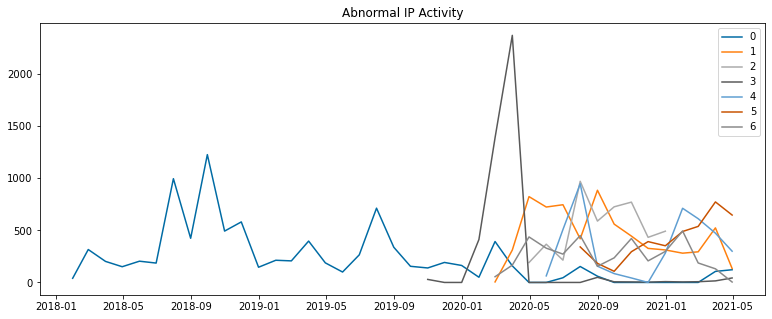

In [5]:
ips = 7
for idx in range(ips):
    plt.plot(df[df.ip==anomaly_ips.index[idx]].resample("M").count().iloc[:,0])
plt.legend(range(ips))
plt.title("Abnormal IP Activity")
plt.show()

I broke the spiky one down my weeks. 3,300 calls in three weeks.

In [6]:
df[df.ip==anomaly_ips.index[3]].resample("W").count().iloc[:,0].sort_values(ascending=False).head()

datetime
2020-03-08    1369
2020-03-15     989
2020-03-01     954
2020-02-09     323
2020-01-26     166
Name: time, dtype: int64

Here I broke down the logs into 20 minute windows and looked for the high-activity ones. I in the next cell, I look at the most active block and find that five cohorts were using the curriculum which doesn't look suspicious because it's many IPs.

In [7]:
pings_per_time = df.ip.resample('20Min').count().sort_values(ascending=False)
print(f'there are {len(pings_per_time)} windows')
anomaly_pings = pings_per_time[pings_per_time > pings_per_time.mean() + stdev*pings_per_time.std()]
anomaly_pings.head(7)

there are 85051 windows


datetime
2020-06-02 09:00:00    375
2021-03-19 09:20:00    345
2021-03-19 09:00:00    323
2021-03-19 09:40:00    321
2020-07-16 09:40:00    306
2021-03-22 09:00:00    298
2020-07-16 09:00:00    291
Name: ip, dtype: int64

In [8]:
idx = 0
new_time = str(anomaly_pings.index[idx])[:-5] + str(int(str(anomaly_pings.index[idx])[-5:-3])+10) + ":00"
small_df = df[(df.index < new_time) & (df.index > anomaly_pings.index[idx])]
small_df.head()

,time,path,user_id,ip,name,start_date,end_date,cohort_path_counts
datetime,,,,,,,,
2020-06-02 09:00:01,09:00:01,mysql,613,104.10.49.137,Apex-Java,2020-02-24,2020-07-29,3835.0
2020-06-02 09:00:06,09:00:06,mysql,598,162.229.67.41,Apex-Java,2020-02-24,2020-07-29,3835.0
2020-06-02 09:00:11,09:00:11,mysql,598,162.229.67.41,Apex-Java,2020-02-24,2020-07-29,3835.0
2020-06-02 09:00:17,09:00:17,mysql,612,172.14.176.83,Apex-Java,2020-02-24,2020-07-29,3835.0
2020-06-02 09:00:17,09:00:17,mysql,606,69.231.76.212,Apex-Java,2020-02-24,2020-07-29,3835.0


In [9]:
small_df.name.unique()

array(['Apex-Java', 'Curie-Data', 'Fortuna-Java', 'Ganymede-Java',
       'Staff-Java'], dtype=object)

## Bollinger bands

I'll visualize the IP calls per day and see when the activity breaks the upper band.

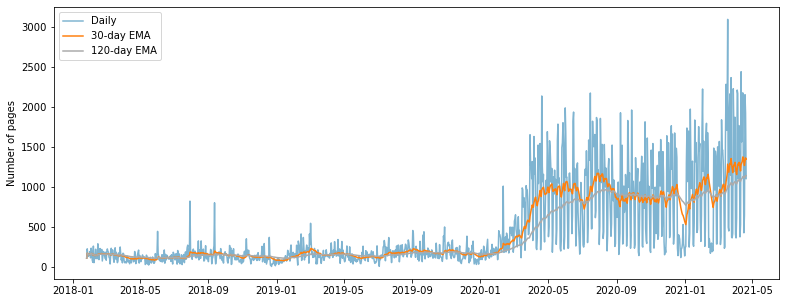

In [10]:
pages = df['path'].resample('d').count()

#EMA
ema_30d = pages.ewm(span=30).mean()
ema_120d = pages.ewm(span=120).mean()

fig, ax = plt.subplots()

ax.plot(pages.index, pages, label='Daily', alpha=.5)
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_120d, label = '120-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

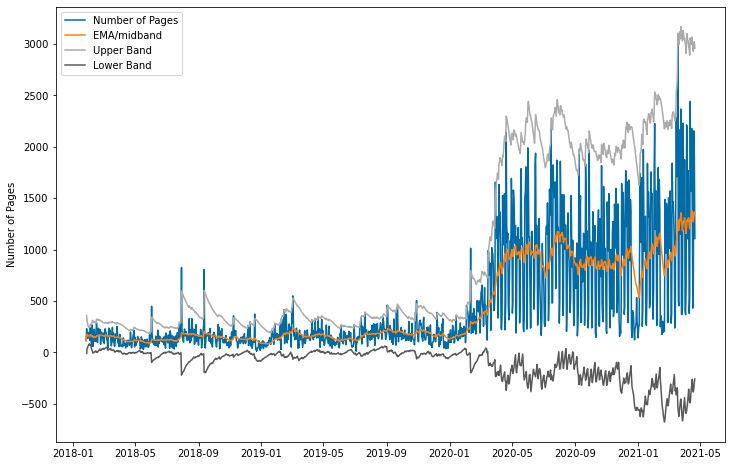

,pages,midband,ub,lb,pct_b
datetime,,,,,
2018-06-02,448,122.296331,342.413887,-97.821226,1.239840
2018-07-30,826,187.877045,596.932224,-221.178134,1.279996
2018-09-12,805,203.801934,603.458527,-195.854659,1.252143
2018-11-08,355,142.924980,334.300161,-48.450201,1.054082
2018-12-10,296,140.246318,290.968664,-10.476028,1.016691
2018-12-19,373,135.607536,328.401904,-57.186832,1.115662
2019-02-14,416,185.863372,414.900533,-43.173789,1.002400
2019-03-03,549,228.790387,525.105004,-67.524230,1.040320
2019-09-02,459,218.044710,420.991762,15.097658,1.093641


In [11]:
bollinger_bands.find_anomalies(pages, span=30, weight=2.25)

## 2. Lessons accessed

Which lesson appears to attract the most traffic consistently across cohorts (per program)?

Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

What topics are grads continuing to reference after graduation and into their jobs (for each program)?

Which lessons are least accessed?

In [12]:
pivot = lessons_prep.lessons_pivot(df)
pivot.sample()

cohort,Andromeda-Java,Apex-Java,Arches-PHP,Badlands-PHP,Bash-Java,Bayes-Data,Betelgeuse-Java,Ceres-Java,Curie-Data,Darden-Data,...,Pinnacles-Java,Quincy-PHP,Sequoia-Java,Teddy-Java,Ulysses-Java,Voyageurs-Java,Wrangell-Java,Xanadu-Java,Yosemite-Java,Zion-Java
lesson,,,,,,,,,,,,,,,,,,,,,
individual-project,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
java, data, php = lessons_prep.divide_lessons_by_program(pivot)

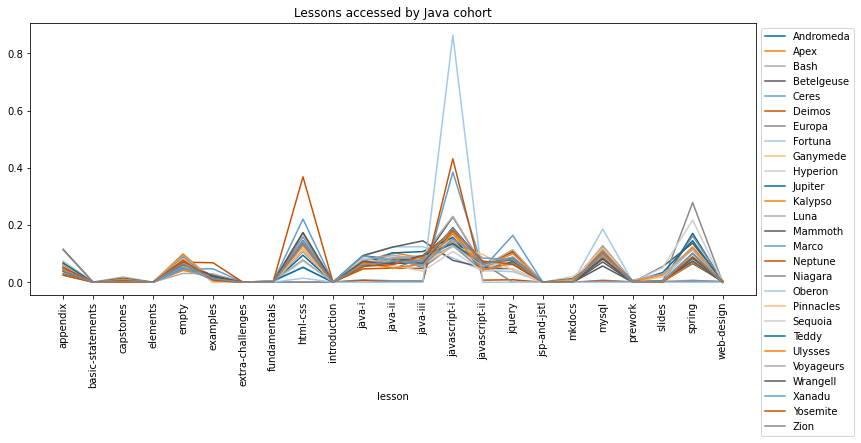

In [18]:
java.plot()
plt.xticks(range(0,len(java.index)), java.index, rotation=90)
ax = plt.subplot(111)
plt.title("Lessons accessed by Java cohort")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

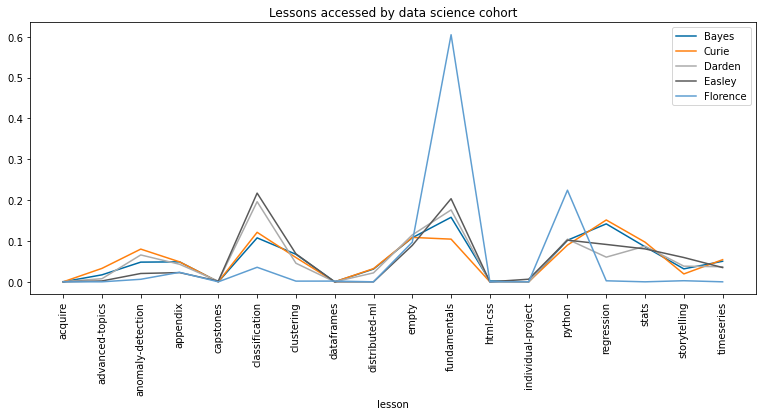

In [19]:
data.plot()
plt.xticks(range(0,len(data.index)), data.index, rotation=90)
plt.title("Lessons accessed by data science cohort")
plt.show()

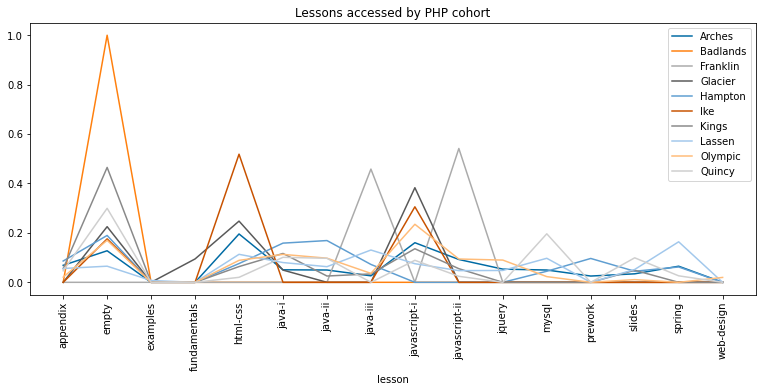

In [20]:
php.plot()
plt.xticks(range(0,len(php.index)), php.index, rotation=90)
plt.title("Lessons accessed by PHP cohort")
plt.show()

In [30]:
#top lessons accessed with percentage by cohort
lessons_prep.most_accessed(java, data, php)

-------
Andromeda 0.1709 spring
Apex 0.142 javascript-i
Bash 0.1749 javascript-i
Betelgeuse 0.2286 javascript-i
Ceres 0.1899 javascript-i
Deimos 0.1798 javascript-i
Europa 0.1618 spring
Fortuna 0.1858 mysql
Ganymede 0.1524 javascript-i
Hyperion 0.1831 javascript-i
Jupiter 0.157 javascript-i
Kalypso 0.1785 javascript-i
Luna 0.2304 javascript-i
Mammoth 0.1448 java-iii
Marco 0.3847 javascript-i
Neptune 0.4315 javascript-i
Niagara 0.2784 spring
Oberon 0.8637 javascript-i
Pinnacles 0.1248 javascript-i
Sequoia 0.2174 spring
Teddy 0.1452 spring
Ulysses 0.1692 javascript-i
Voyageurs 0.1271 javascript-i
Wrangell 0.1907 javascript-i
Xanadu 0.151 javascript-i
Yosemite 0.1814 javascript-i
Zion 0.1876 javascript-i
-------
Bayes 0.158 fundamentals
Curie 0.1514 regression
Darden 0.1962 classification
Easley 0.2172 classification
Florence 0.6049 fundamentals
-------
Arches 0.1957 html-css
Badlands 1.0 empty
Franklin 0.5417 javascript-ii
Glacier 0.3829 javascript-i
Hampton 0.1897 empty
Ike 0.5185 html-

In [29]:
#lessons rankes by percentage accessed by program
lessons_prep.mean_access_rate(java, data, php)

-------
lesson
javascript-i        0.201774
html-css            0.119637
spring              0.099148
mysql               0.092478
java-iii            0.072022
jquery              0.071511
java-ii             0.071185
empty               0.067230
java-i              0.062604
appendix            0.054989
javascript-ii       0.052930
examples            0.015274
slides              0.009293
capstones           0.003741
mkdocs              0.002085
web-design          0.001981
prework             0.001419
fundamentals        0.000496
introduction        0.000052
jsp-and-jstl        0.000041
extra-challenges    0.000037
basic-statements    0.000026
elements            0.000026
dtype: float64
-------
lesson
fundamentals          0.24938
classification        0.13556
python                0.12446
empty                 0.10356
regression            0.08954
stats                 0.07014
clustering            0.04852
anomaly-detection     0.04414
appendix              0.03734
timeseries        

In [28]:
#these lessons were accessed to a much higher degree by these cohorts
lessons_prep.outlier_activity(java, data, php, stdev=2.5)

-------
['Mammoth', 'Niagara'] appendix
['Bash'] basic-statements
['Bash'] capstones
['Apex'] elements
['Neptune'] examples
['Kalypso'] extra-challenges
['Teddy', 'Voyageurs'] fundamentals
['Neptune'] html-css
['Marco'] introduction
['Oberon'] javascript-i
['Marco'] jquery
['Europa'] jsp-and-jstl
['Sequoia'] mkdocs
['Voyageurs'] prework
['Mammoth', 'Sequoia'] slides
['Niagara'] spring
-------
-------
['Badlands'] empty
['Lassen'] examples
['Glacier'] fundamentals
['Franklin'] java-iii
['Franklin'] javascript-ii
['Hampton'] prework
['Olympic'] web-design


## Post-graduation

In [21]:
df2 = df[df.index > pd.to_datetime(df.end_date)]
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 152136 entries, 2018-01-26 10:59:02 to 2021-04-21 16:44:39
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   time                152136 non-null  object 
 1   path                152136 non-null  object 
 2   user_id             152136 non-null  int64  
 3   ip                  152136 non-null  object 
 4   name                152136 non-null  object 
 5   start_date          152136 non-null  object 
 6   end_date            152136 non-null  object 
 7   cohort_path_counts  152136 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 10.4+ MB


In [22]:
pivot2 = lessons_prep.lessons_pivot(df2)
pivot2.sample()

cohort,Andromeda-Java,Apex-Java,Arches-PHP,Badlands-PHP,Bash-Java,Bayes-Data,Betelgeuse-Java,Ceres-Java,Curie-Data,Darden-Data,...,Pinnacles-Java,Quincy-PHP,Sequoia-Java,Teddy-Java,Ulysses-Java,Voyageurs-Java,Wrangell-Java,Xanadu-Java,Yosemite-Java,Zion-Java
lesson,,,,,,,,,,,,,,,,,,,,,
mkdocs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,67.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
java_p, data_p, php_p = lessons_prep.divide_lessons_by_program(pivot2)

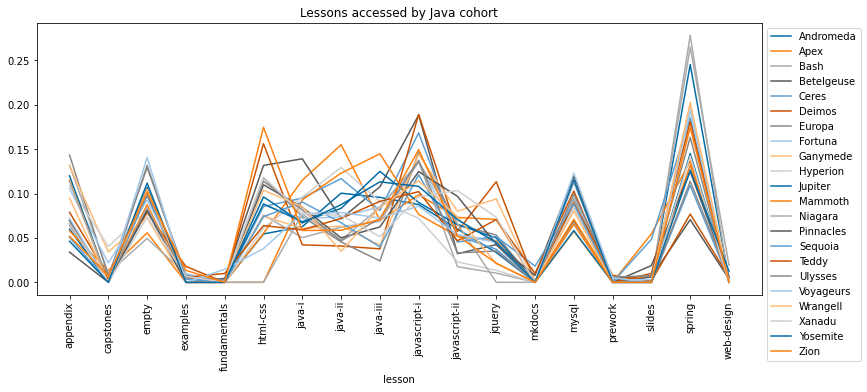

In [25]:
java_p.plot()
plt.xticks(range(0,len(java_p.index)), java_p.index, rotation=90)
ax = plt.subplot(111)
plt.title("Lessons accessed by Java cohort")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

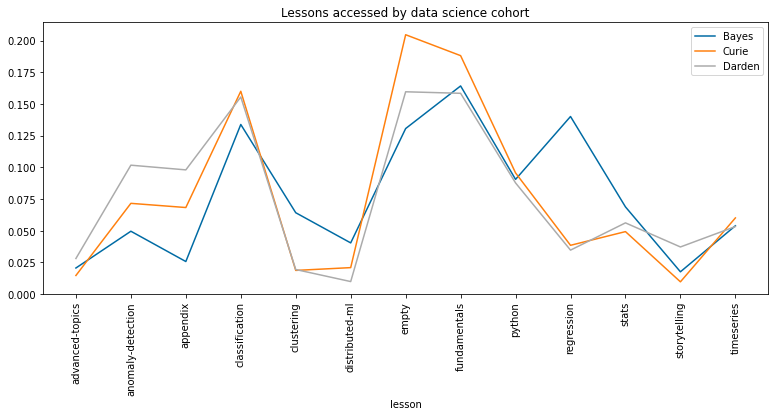

In [26]:
data_p.plot()
plt.xticks(range(0,len(data_p.index)), data_p.index, rotation=90)
plt.title("Lessons accessed by data science cohort")
plt.show()

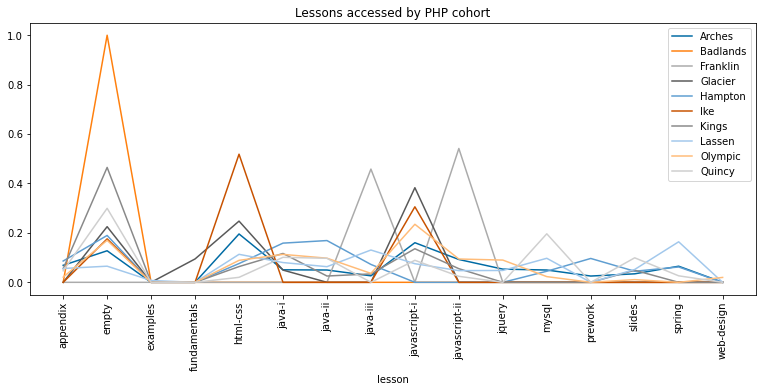

In [27]:
php_p.plot()
plt.xticks(range(0,len(php_p.index)), php_p.index, rotation=90)
plt.title("Lessons accessed by PHP cohort")
plt.show()

In [24]:
lessons_prep.most_accessed(java_p, data_p, php_p)

-------
Andromeda 0.2453 spring
Apex 0.155 java-ii
Bash 0.2652 spring
Betelgeuse 0.1885 javascript-i
Ceres 0.1684 javascript-i
Deimos 0.1891 javascript-i
Europa 0.147 javascript-i
Fortuna 0.1418 spring
Ganymede 0.1442 javascript-i
Hyperion 0.1998 spring
Jupiter 0.145 spring
Mammoth 0.1448 java-iii
Niagara 0.2784 spring
Pinnacles 0.1248 javascript-i
Sequoia 0.1853 spring
Teddy 0.1811 spring
Ulysses 0.1633 spring
Voyageurs 0.1935 spring
Wrangell 0.2028 spring
Xanadu 0.1423 spring
Yosemite 0.1265 spring
Zion 0.1747 html-css
-------
Bayes 0.1642 fundamentals
Curie 0.2046 empty
Darden 0.1596 empty
-------
Arches 0.1957 html-css
Badlands 1.0 empty
Franklin 0.5417 javascript-ii
Glacier 0.3829 javascript-i
Hampton 0.1897 empty
Ike 0.5185 html-css
Kings 0.465 empty
Lassen 0.164 spring
Olympic 0.2349 javascript-i
Quincy 0.2996 empty
